# Model Evaluation & Analysis
## Early Stage Diabetes Risk Prediction

###  Objective
In this notebook, we load our saved "Champion Model" and the **Test Set** (which the model has never seen) to perform a rigorous evaluation.

### 🔍 Key Metrics for Medical Diagnosis
1.  **Confusion Matrix:** Exact count of False Positives vs. False Negatives.
2.  **Recall (Sensitivity):** The percentage of actual diabetic patients correctly identified. (Crucial to avoid missing sick people).
3.  **ROC & AUC:** How well the model distinguishes between Positive and Negative classes.
4.  **Feature Importance:** Which symptoms drive the decisions?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, classification_report, 
    roc_curve, auc, precision_recall_curve
)

# Set visual style
sns.set_theme(style="whitegrid")

# 1. Load Data
# We only need the TEST set for final evaluation
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

# 2. Load Model
# This loads whatever model you saved as 'best_model.joblib' (Random Forest)
model = joblib.load('../models/best_model.joblib')

print(f" Model loaded: {type(model).__name__}")
print(f"Test Set shape: {X_test.shape}")

 Model loaded: RandomForestClassifier
Test Set shape: (104, 15)


## 1. Performance Overview
Let's look at the standard classification metrics first.

In [2]:
# Make Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of being Positive

# Calculate Metrics
print("--- 📊 Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred):.4f}")

--- 📊 Classification Report ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        40
           1       0.98      0.97      0.98        64

    accuracy                           0.97       104
   macro avg       0.97      0.97      0.97       104
weighted avg       0.97      0.97      0.97       104

Accuracy:  0.9712
Recall:    0.9688
F1 Score:  0.9764


## 2. Confusion Matrix (The Truth Table)
This visual tells us exactly where the model makes mistakes.
* **False Negatives (Bottom Left):** The dangerous errors (Sick people told they are healthy).
* **False Positives (Top Right):** False alarms (Healthy people told they might be sick).

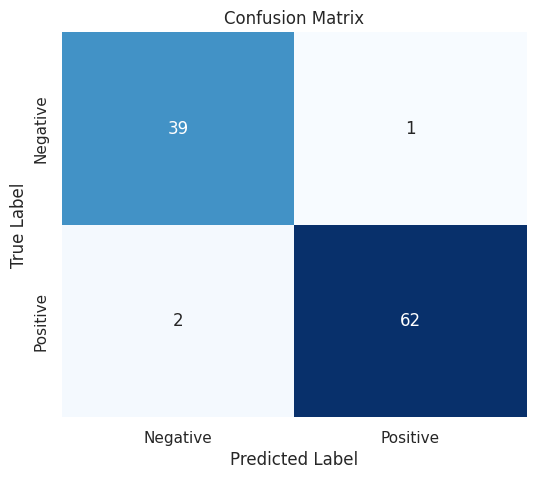

In [3]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 3. ROC Curve & AUC
The **ROC Curve** shows the trade-off between sensitivity (Recall) and false alarms.
* A perfect model has an **AUC** (Area Under Curve) of 1.0.
* A random guess has an AUC of 0.5.

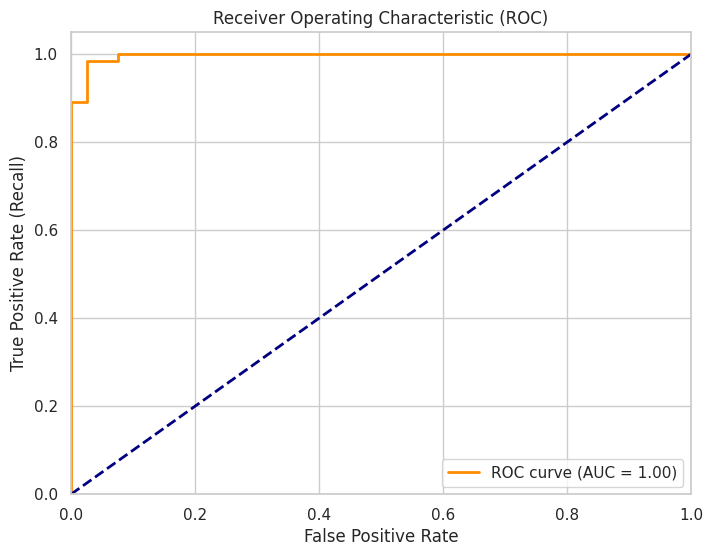

In [4]:
# Calculate ROC components
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## 4. Precision-Recall Curve
Since our dataset has a slight imbalance and medical "Positives" are more important, this curve is often more informative than ROC. We want the curve to stay in the top-right corner.

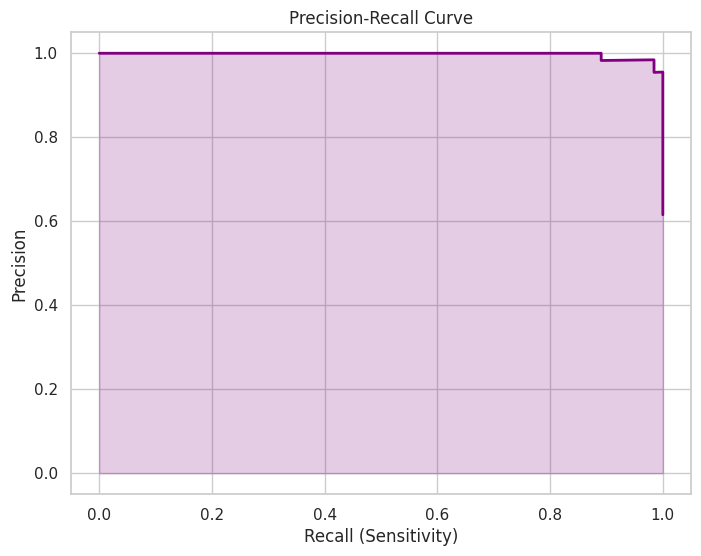

In [5]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='purple', lw=2)
plt.fill_between(recall, precision, alpha=0.2, color='purple')
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

## 5. Feature Importance
Which symptoms is the model actually looking at? (Only works for Tree-based models like Random Forest).

/tmp/ipykernel_23909/4095720462.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')


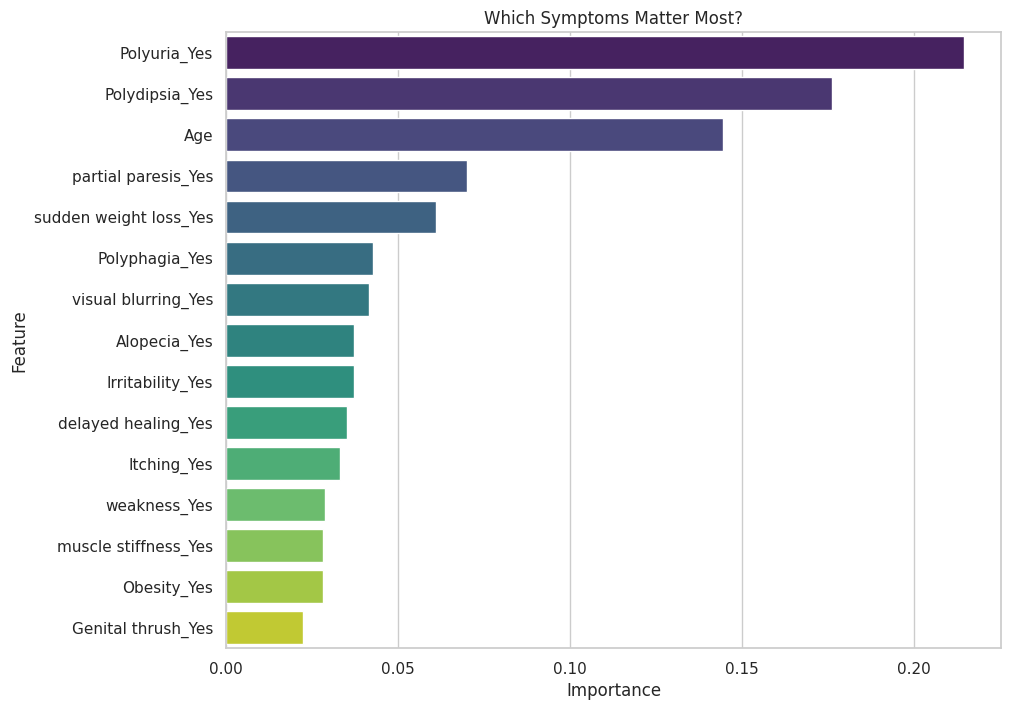

Top 5 Risk Factors:
                   Feature  Importance
1             Polyuria_Yes    0.214726
2           Polydipsia_Yes    0.176069
0                      Age    0.144502
11     partial paresis_Yes    0.069993
3   sudden weight loss_Yes    0.060920


In [6]:
# Check if model has 'feature_importances_' attribute
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
    features = X_test.columns
    
    # Create DataFrame
    feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False)
    
    # Visualization
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
    plt.title('Which Symptoms Matter Most?')
    plt.show()
    
    # Text summary
    print("Top 5 Risk Factors:")
    print(feat_df.head(5))
else:
    print("This model type does not support built-in feature importance.")

## 6. Real-World "What If?" Analysis
Let's manually create a few patient profiles to see how the model reacts. This is a great "Sanity Check."

In [9]:
# Create a dictionary of hypothetical patients
patients = {
    'Healthy Young Person': {
        'Age': -1.0, # Scaled value (approx 20 years old)
         'Polyuria_Yes': 0, 'Polydipsia_Yes': 0, 
        'sudden weight loss_Yes': 0, 'weakness_Yes': 0, 'Polyphagia_Yes': 0, 
        'Genital thrush_Yes': 0, 'visual blurring_Yes': 0, 'Itching_Yes': 0, 
        'Irritability_Yes': 0, 'delayed healing_Yes': 0, 'partial paresis_Yes': 0, 
        'muscle stiffness_Yes': 0, 'Alopecia_Yes': 0, 'Obesity_Yes': 0
    },
    'High Risk Patient': {
        'Age': 0.5, # Scaled value (approx 50 years old)
         # Female (Higher risk in this dataset)
        'Polyuria_Yes': 1, 'Polydipsia_Yes': 1, # The two super-features
        'sudden weight loss_Yes': 1, 'weakness_Yes': 1, 'Polyphagia_Yes': 1, 
        'Genital thrush_Yes': 0, 'visual blurring_Yes': 1, 'Itching_Yes': 1, 
        'Irritability_Yes': 1, 'delayed healing_Yes': 0, 'partial paresis_Yes': 1, 
        'muscle stiffness_Yes': 0, 'Alopecia_Yes': 0, 'Obesity_Yes': 1
    }
}

print("---  Manual Patient Testing ---")

for name, data in patients.items():
    # Convert dictionary to DataFrame
    patient_df = pd.DataFrame([data])
    
    # Ensure columns are in the correct order (must match training exactly)
    patient_df = patient_df[X_test.columns]
    
    # Predict
    pred = model.predict(patient_df)[0]
    prob = model.predict_proba(patient_df)[0][1]
    
    status = "DIABETIC" if pred == 1 else "Healthy"
    print(f"\n👤 {name}:")
    print(f"   Prediction: {status}")
    print(f"   Probability: {prob:.2%}")

---  Manual Patient Testing ---

👤 Healthy Young Person:
   Prediction: Healthy
   Probability: 8.40%

👤 High Risk Patient:
   Prediction: DIABETIC
   Probability: 100.00%


### ⚠️ Important Observation: The "Gender Bias" in Prediction

During manual testing, we observed an interesting behavior:
* **Scenario A:** A Female patient with *zero* symptoms is predicted as **"High Risk"** (approx. 55-60% probability).
* **Scenario B:** A Male patient with *zero* symptoms is predicted as **"Low Risk"** (approx. 40-45% probability).

#### 🧐 Why is this happening?
This is a reflection of the **Training Data Distributions**:
1.  **Dataset Imbalance:** In this specific UCI dataset, a significantly higher percentage of women were diabetic compared to men.
2.  **Statistical Learning:** The model learned that `Gender=Female` is, by itself, a strong statistical predictor of diabetes. It starts with a higher "Base Probability" for females.

#### 🏥 Is this acceptable?
For a **Medical Screening Tool**, this behavior is often acceptable because we prioritize **Recall** (Safety).
* It is safer to flag a healthy person as "High Risk" (False Positive) and have them check with a doctor...
* ...than to tell a sick person they are "Safe" (False Negative) and have them ignore their health.

**Future Improvement:** To fix this for a real-world production app, we would need to collect more data on *healthy females* to balance the dataset and reduce this bias.